In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

# We need this to import from the folders above
import sys
sys.path.append('..')

# like this one
from building_blocks.gqn import GenerativeQueryNetwork
from building_blocks.training import partition
from data.datasets import ShepardMetzler, Scene, transform_viewpoint

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Inside the computer's mind

## Step 1. Loading the model from checkpoint

This notebook demonstrates the basics of loading a trained checkpoint of our GQN model, and using it to do all the things we wish it could do. Given a set of context viewpoints and images for a scene, we can *represent* that scene, and *ask* the model to use that representation to tell us what the scene would look like from a different perspective.

In [4]:
# check for GPU
cuda = torch.cuda.is_available()
device = 'cuda:0' if cuda else 'cpu'
map_location = None if cuda else 'cpu'
print("Got GPU?", "yes" if cuda else "no")

Got GPU? yes


In [5]:
# load the checkpointed model
checkpoint_path = '../checkpoints/checkpoint_model_20000.pth'

def load(checkpoint):
    # the fun thing is, since this is a shared-core model, we can change L to be different
    model = GenerativeQueryNetwork(x_dim=3, v_dim=7, r_dim=256, h_dim=128, z_dim=64, L=8)
    weights = torch.load(checkpoint, map_location=map_location)

    # weights were trained on GPU
    model = nn.DataParallel(model)
    model.load_state_dict(weights)
    return model.module

model = load(checkpoint_path)
model

GenerativeQueryNetwork(
  (generator): GeneratorNetwork(
    (inference_core): Conv2dLSTMCell(
      (forget): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (input): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (output): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (state): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (transform): Conv2d(128, 394, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (generator_core): Conv2dLSTMCell(
      (forget): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (input): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (output): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (state): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (transform): Conv2d(128, 327, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (posterio

## Step 2: Grab some data

In [38]:
def getLoader(data_dir, batch_size=1, transform_views=True):
    test_dataset = ShepardMetzler(root_dir=data_dir, train=False, transform_views=transform_views)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    i = iter(test_loader)
    return i

loader = getLoader('../data/shepard_metzler_5_parts-torch', batch_size=1)
images,v = next(loader)
print(images.size(), v.size())

torch.Size([1, 15, 3, 64, 64]) torch.Size([1, 15, 7])


We'll need some plotting functions

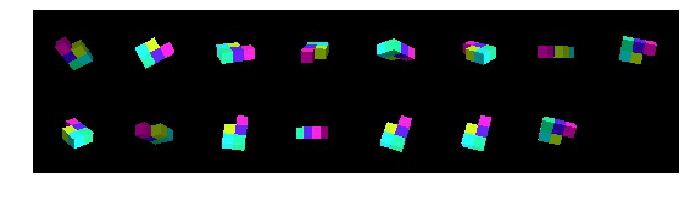

In [51]:
def show(img, figsize=(12,3)):
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def show_grid(x):
    images = [x.squeeze() for x in torch.split(x[0], 1)]
    show(make_grid(images))

show_grid(images)

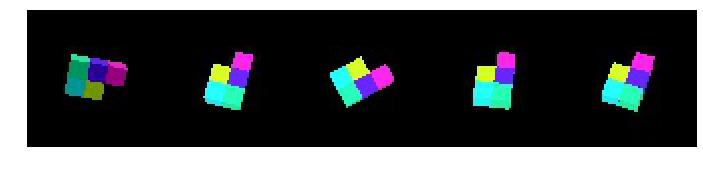

In [52]:
context_images, context_viewpoint, target_image, query_viewpoint = partition(images,v)
show_grid(context_images)

Query view: torch.Size([1, 7]) tensor([[-3.1140, -0.5940,  1.0301,  0.9823, -0.1874,  0.9511, -0.3090]])
target img: torch.Size([1, 3, 64, 64])


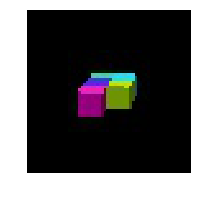

In [53]:
print("Query view:", query_viewpoint.size(), query_viewpoint)
print("target img:", target_image.size())
show_grid(target_image)

## Step 3: Query the model

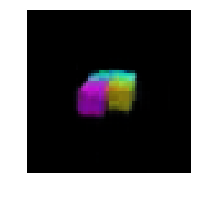

In [54]:
def queryModel(a, b, c):
    a, b, c = a.to(device), b.to(device), c.to(device)
    with torch.no_grad():
        x_mu = model.sample(a, b, c, sigma=0.2)
    return x_mu.cpu()

x_mu = queryModel(context_images, context_viewpoint, query_viewpoint)
show_grid(x_mu)

## Step 4: Create fancy rotation visuals :)

Let's generate a set of query viewpoints which are rotated all around the object. This will be easier if we load the data with the original (untransformed) yaw and pitch.

In [120]:
rotateLoader = getLoader('../data/shepard_metzler_5_parts-torch', batch_size=1, transform_views=False)
x,v = next(rotateLoader)
print(v.size())

torch.Size([1, 15, 5])


In [121]:
print(v)

tensor([[[ 2.3334,  2.1912, -0.9300,  2.3876,  0.2827],
         [-2.3880, -1.9755, -1.2271,  5.5920,  0.3770],
         [-2.7159, -1.4931, -1.2271,  5.7805,  0.3770],
         [ 0.2663, -0.3219, -3.3070,  4.0212,  1.4451],
         [-1.3196, -0.5225, -3.0161,  5.9062,  1.1310],
         [ 0.3981,  2.0871, -2.5684,  1.7593,  0.8796],
         [ 2.5896,  1.8815,  0.9300,  2.5133, -0.2827],
         [-2.4165, -1.9991, -1.1291,  5.5920,  0.3456],
         [-0.1767, -2.8089,  1.7861,  4.7752, -0.5655],
         [ 3.0611, -1.2120,  0.5214,  3.5186, -0.1571],
         [ 2.5896, -1.8815,  0.9300,  3.7699, -0.2827],
         [ 2.5511,  0.6550,  2.0430,  2.8903, -0.6597],
         [ 0.2013, -1.5932, -2.9210,  4.5867,  1.0681],
         [-0.1894, -0.0891, -3.3268,  5.8434,  1.5080],
         [ 3.1004,  0.7961,  0.9300,  2.8903, -0.2827]]])


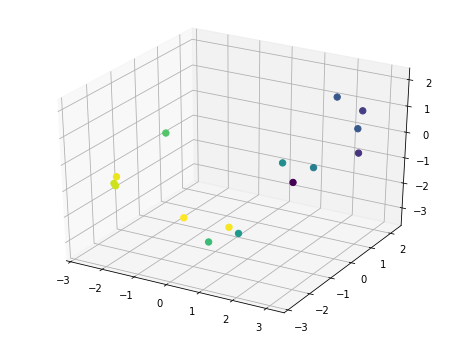

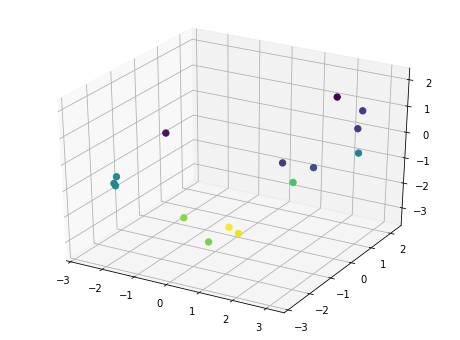

In [122]:
from mpl_toolkits.mplot3d import Axes3D

yaw = v[0,:,3]
pitch = v[0,:,4]

# show camera positions and yaw
kwargs = {'s': 40, 'alpha': 1.0, 'c': yaw}
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*torch.split(v[0,:,:3], 1, 1), **kwargs)
plt.show()

# show camera positions and pitch
kwargs = {'s': 40, 'alpha': 1.0, 'c': pitch}
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*torch.split(v[0,:,:3], 1, 1), **kwargs)
plt.show()

So, `yaw` goes from $0$ to $2\pi$ and `pitch` goes from $-\pi$ to $\pi$

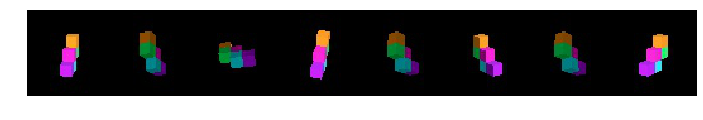

In [123]:
v = transform_viewpoint(v)
context_images, context_viewpoint, target_image, query_viewpoint = partition(x,v)
show_grid(context_images)

tensor([[ 3.1004,  0.7961,  0.9300, -0.9686,  0.2487,  0.9603, -0.2790]])
tensor([[ 2.8360,  0.6920,  0.8319, -0.8847,  0.2155,  0.9589, -0.2496]])
tensor([[ 2.5717,  0.5879,  0.7339, -0.8009,  0.1823,  0.9575, -0.2202]])
tensor([[ 2.3073,  0.4839,  0.6358, -0.7170,  0.1491,  0.9561, -0.1907]])
tensor([[ 2.0429,  0.3798,  0.5378, -0.6331,  0.1159,  0.9547, -0.1613]])
tensor([[ 1.7785,  0.2758,  0.4397, -0.5493,  0.0827,  0.9534, -0.1319]])
tensor([[ 1.5141,  0.1717,  0.3417, -0.4654,  0.0495,  0.9520, -0.1025]])
tensor([[ 1.2498,  0.0677,  0.2436, -0.3816,  0.0163,  0.9506, -0.0731]])
tensor([[ 0.9854, -0.0364,  0.1456, -0.2977, -0.0169,  0.9492, -0.0437]])
tensor([[ 0.7210, -0.1404,  0.0475, -0.2139, -0.0501,  0.9478, -0.0143]])
tensor([[ 0.4566, -0.2445, -0.0505, -0.1300, -0.0833,  0.9464,  0.0152]])
tensor([[ 0.1923, -0.3485, -0.1486, -0.0461, -0.1165,  0.9450,  0.0446]])
tensor([[-0.0721, -0.4526, -0.2466,  0.0377, -0.1497,  0.9436,  0.0740]])
tensor([[-0.3365, -0.5566, -0.3447,  0

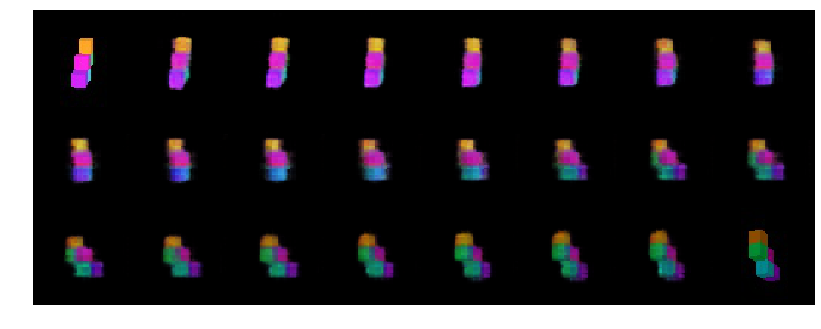

In [142]:
def interpolate(v0, v1, n = 5):
    diff = v1 - v0
    return [v0 + diff * k/n for k in range(n)]

def transition(from_idx, to_idx, n=5):
    between = interpolate(context_viewpoint[:, from_idx], context_viewpoint[:, to_idx], n)
    for a in between:
        print(a)
    pictures = [queryModel(context_images, context_viewpoint, x).squeeze() for x in between]
    pictures = [context_images[:, from_idx].squeeze()] + pictures + [context_images[:, to_idx].squeeze()]
    show(make_grid(pictures), figsize=(14,14))
    
transition(0,1, 22)

tensor([[ 2.5511,  0.6550,  2.0430, -0.9686,  0.2487,  0.7902, -0.6129]])
tensor([[ 2.5524,  0.6959,  2.0059, -0.9633,  0.2600,  0.7958, -0.6018]])
tensor([[ 2.5537,  0.7368,  1.9688, -0.9579,  0.2713,  0.8015, -0.5906]])
tensor([[ 2.5550,  0.7777,  1.9317, -0.9526,  0.2826,  0.8072, -0.5795]])
tensor([[ 2.5562,  0.8185,  1.8946, -0.9473,  0.2939,  0.8128, -0.5684]])
tensor([[ 2.5575,  0.8594,  1.8575, -0.9420,  0.3052,  0.8185, -0.5573]])
tensor([[ 2.5588,  0.9003,  1.8204, -0.9367,  0.3165,  0.8242, -0.5461]])
tensor([[ 2.5601,  0.9412,  1.7833, -0.9314,  0.3278,  0.8299, -0.5350]])
tensor([[ 2.5614,  0.9821,  1.7462, -0.9260,  0.3391,  0.8355, -0.5239]])
tensor([[ 2.5627,  1.0230,  1.7091, -0.9207,  0.3504,  0.8412, -0.5127]])
tensor([[ 2.5640,  1.0638,  1.6720, -0.9154,  0.3617,  0.8469, -0.5016]])
tensor([[ 2.5652,  1.1047,  1.6349, -0.9101,  0.3730,  0.8525, -0.4905]])
tensor([[ 2.5665,  1.1456,  1.5978, -0.9048,  0.3843,  0.8582, -0.4793]])
tensor([[ 2.5678,  1.1865,  1.5607, -0

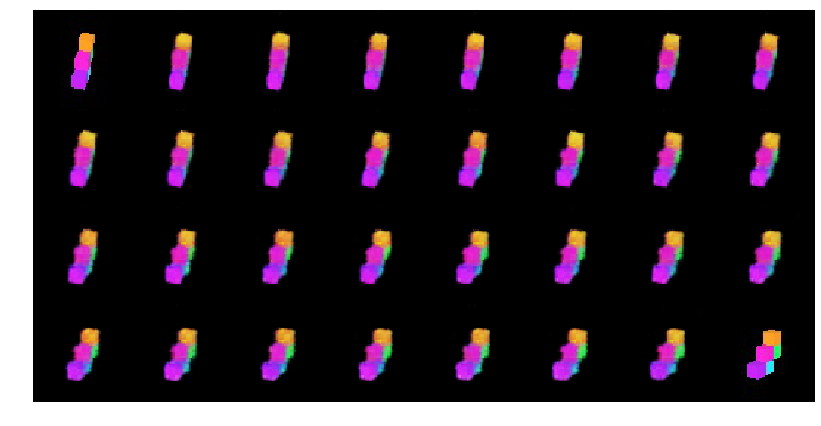

In [132]:
transition(3, 7, 30)